In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib
import warnings
warnings.simplefilter(action='ignore')
sns.set()
plt.style.use("ggplot")

In [3]:
# Funzione per generare un report con figure
def create_figure(fig_num, title):
    plt.figure(figsize=(10, 6))
    plt.suptitle(title, fontsize=16)
    return plt

# Caricamento del dataset
print("Caricamento del dataset...")
df = pd.read_csv(r"C:\Users\imada\Desktop\MACHINE_LEARNING\models\diabetes.csv")
print(f"Dimensioni del dataset: {df.shape}")

Caricamento del dataset...
Dimensioni del dataset: (768, 9)


In [38]:
# Salviamo la variabile target separatamente
target = df['Outcome']

# Selezione delle 4 feature già presenti nel dataset senza fare imputazione
selected_features = ['Glucose', 'BloodPressure', 'Insulin', 'BMI']
X_selected_df = df[selected_features]

# Se vuoi mantenere le colonne categoriche (se già presenti)
categorical_columns = ['BMI_Category', 'Insulin_Category', 'Glucose_Category']
categorical_df = df[categorical_columns] if all(col in df.columns for col in categorical_columns) else pd.DataFrame()

# Ricostruisci il DataFrame finale, concatenando le colonne selezionate + categoriche (se esistono) + target
df_final = pd.concat([X_selected_df, categorical_df, target], axis=1)



                            EDA

In [39]:
print("\n1. ESPLORAZIONE DEI DATI")

# Visualizzazione delle prime righe
print("\nPrime 5 righe del dataset:")
print(df.head())

# Informazioni sul dataset
print("\nInformazioni sul dataset:")
df.info()

# Statistiche descrittive
print("\nStatistiche descrittive:")
df.describe()


1. ESPLORAZIONE DEI DATI

Prime 5 righe del dataset:
   Glucose  BloodPressure   Insulin   BMI  Outcome
0    148.0           72.0  208.5000  33.6        1
1     85.0           66.0   64.1000  26.6        0
2    183.0           64.0  179.3625  23.3        1
3     89.0           66.0   94.0000  28.1        0
4    137.0           40.0  168.0000  43.1        1

Informazioni sul dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Glucose        768 non-null    float64
 1   BloodPressure  768 non-null    float64
 2   Insulin        768 non-null    float64
 3   BMI            768 non-null    float64
 4   Outcome        768 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 30.1 KB

Statistiche descrittive:


,Glucose,BloodPressure,Insulin,BMI,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000
mean,121.603776,72.380990,145.022363,32.445547,0.348958
std,30.474055,12.196972,77.507030,6.893329,0.476951
min,44.000000,24.000000,14.000000,18.200000,0.000000
25%,99.000000,64.000000,87.000000,27.500000,0.000000
50%,117.000000,72.000000,129.400000,32.050000,0.000000
75%,140.250000,80.000000,189.021875,36.600000,1.000000
max,199.000000,122.000000,360.625000,67.100000,1.000000



Distribuzione della variabile target:
Non diabetici (0): 500 (65.1%)
Diabetici (1): 268 (34.9%)


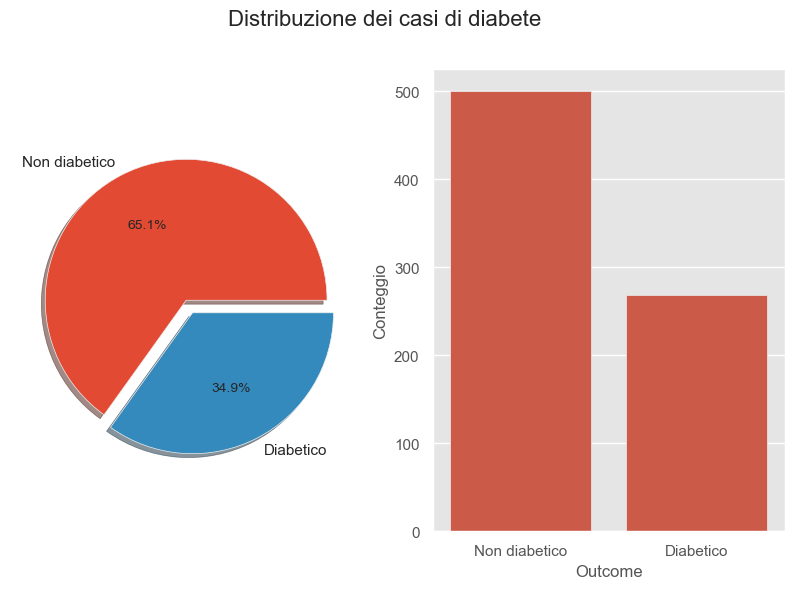

In [40]:
# Distribuzione della variabile target
outcome_counts = df["Outcome"].value_counts()
print(f"\nDistribuzione della variabile target:")
print(f"Non diabetici (0): {outcome_counts[0]} ({outcome_counts[0]*100/len(df):.1f}%)")
print(f"Diabetici (1): {outcome_counts[1]} ({outcome_counts[1]*100/len(df):.1f}%)")

# Distribuzione grafica della variabile target
fig = create_figure(1, "Distribuzione dei casi di diabete")
plt.subplot(1, 2, 1)
df['Outcome'].value_counts().plot.pie(
    explode=[0, 0.1],
    autopct="%1.1f%%",
    shadow=True,
    labels=['Non diabetico', 'Diabetico']
)
plt.ylabel('')

plt.subplot(1, 2, 2)
sns.countplot(x='Outcome', data=df)
plt.xticks([0, 1], ['Non diabetico', 'Diabetico'])
plt.xlabel('Outcome')
plt.ylabel('Conteggio')
plt.savefig('distribuzione_target.png')

KeyError: 'Pregnancies'

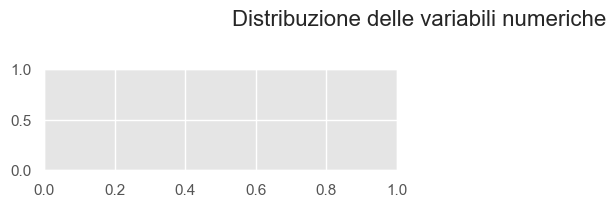

In [41]:
# Visualizzazione della distribuzione delle variabili
fig = create_figure(2, "Distribuzione delle variabili numeriche")
cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
for i, col in enumerate(cols):
    plt.subplot(4, 2, i+1)
    sns.histplot(df[col], kde=True, color="red")
    plt.xlabel(col)
    plt.ylabel('Frequenza')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('distribuzione_variabili.png')

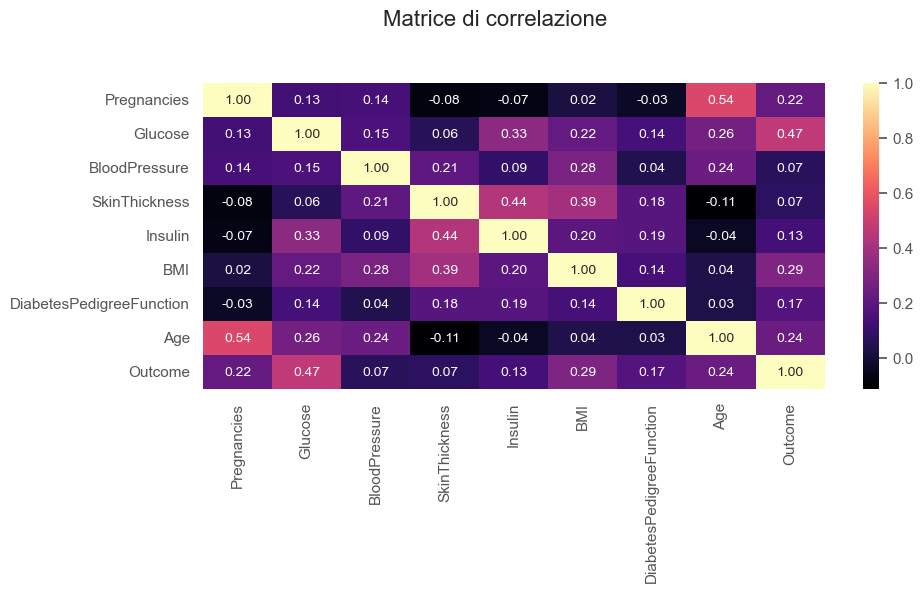

In [7]:
# Matrice di correlazione
fig = create_figure(3, "Matrice di correlazione")
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='magma')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('matrice_correlazione.png')

In [42]:
# Differenze tra gruppi
print("\nDifferenze tra diabetici e non diabetici:")
group_comparison = df.groupby("Outcome").agg({
    'Pregnancies': ['mean', 'median'],
    'Glucose': ['mean', 'median'],
    'BMI': ['mean', 'median'],
    'Age': ['mean', 'median']
})
print(group_comparison.to_string())


Differenze tra diabetici e non diabetici:


KeyError: "Column(s) ['Age', 'Pregnancies'] do not exist"

                    PREPROCESSING DEI DATI


In [43]:
print("\n2. PREPROCESSING DEI DATI")

# Identificazione di valori sospetti (0) in colonne dove non dovrebbero esistere
print("\nConteggio di valori 0 nelle colonne (potenziali valori mancanti):")
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    zero_count = (df[col] == 0).sum()
    print(f"{col}: {zero_count} ({zero_count*100/len(df):.1f}%)")

# Sostituzione degli 0 con NaN per le colonne rilevanti
print("\nSostituzione degli 0 con NaN per le colonne dove 0 non è un valore plausibile...")
cols_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_to_replace] = df[cols_to_replace].replace(0, np.NaN)

# Conteggio dei valori mancanti
print("\nValori mancanti dopo la sostituzione:")
print(df.isnull().sum())


2. PREPROCESSING DEI DATI

Conteggio di valori 0 nelle colonne (potenziali valori mancanti):
Glucose: 0 (0.0%)
BloodPressure: 0 (0.0%)


KeyError: 'SkinThickness'

In [44]:

# Imputazione avanzata con Random Forest
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Applichiamo Random Forest Imputation
rf_imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=10, random_state=0),
    max_iter=10,
    random_state=0
)
X = df.drop(columns="Outcome")  # cambia "Outcome" con il nome corretto della tua colonna target, se diverso

X_imputed = rf_imputer.fit_transform(X)

# Se X era un DataFrame, convertiamo di nuovo
X_imputed = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)


                RILEVAMENTO DEGLI OUTLIER

In [45]:
print("\nRilevamento degli outlier con il metodo IQR:")
# Salta colonne non numeriche o categoriali
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns
for feature in numeric_features:
    # Salta la colonna Outcome e is_outlier
    if feature in ['Outcome', 'is_outlier']:
        continue
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    n_outliers = sum((df[feature] < lower) | (df[feature] > upper))
    if n_outliers > 0:
        print(f"{feature}: {n_outliers} outlier rilevati ({n_outliers*100/len(df):.1f}%)")


Rilevamento degli outlier con il metodo IQR:
BloodPressure: 14 outlier rilevati (1.8%)
Insulin: 25 outlier rilevati (3.3%)
BMI: 8 outlier rilevati (1.0%)



Trattamento degli outlier per Insulin...
Limite superiore per Insulin: 342.0546875


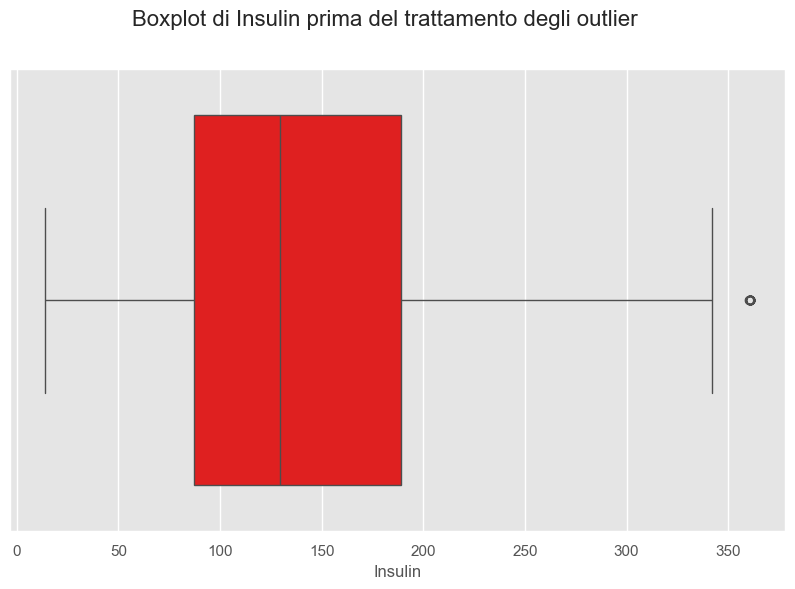

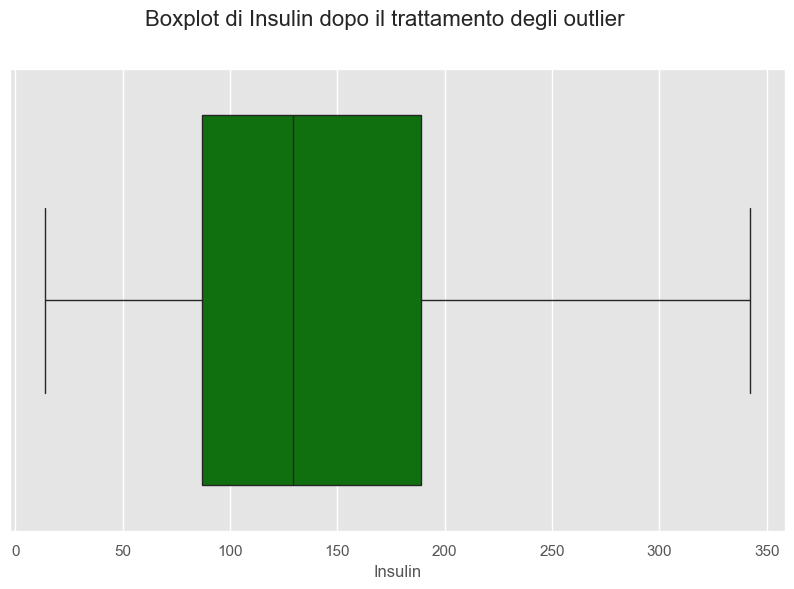

In [46]:
 #Trattamento degli outlier per Insulin (solo come esempio)
print("\nTrattamento degli outlier per Insulin...")
fig = create_figure(4, "Boxplot di Insulin prima del trattamento degli outlier")
sns.boxplot(x=df["Insulin"], color="red")
plt.xlabel("Insulin")
plt.savefig('insulin_prima.png')

Q1 = df.Insulin.quantile(0.25)
Q3 = df.Insulin.quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
print(f"Limite superiore per Insulin: {upper}")
df.loc[df['Insulin'] > upper, "Insulin"] = upper

fig = create_figure(5, "Boxplot di Insulin dopo il trattamento degli outlier")
sns.boxplot(x=df["Insulin"], color="green")
plt.xlabel("Insulin")
plt.savefig('insulin_dopo.png')

In [47]:

# Imputazione avanzata con Random Forest
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Applichiamo Random Forest Imputation
rf_imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=10, random_state=0),
    max_iter=10,
    random_state=0
)

X_imputed = rf_imputer.fit_transform(X)

# Se X era un DataFrame, convertiamo di nuovo
X_imputed = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)


In [49]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

target = df['Outcome']

numeric_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                   'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Filtra solo colonne presenti
numeric_columns = [col for col in numeric_columns if col in df.columns]

X_num = df[numeric_columns]

rf_imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=10, random_state=0),
    max_iter=10,
    random_state=0
)

X_imputed = rf_imputer.fit_transform(X_num)
X_imputed_df = pd.DataFrame(X_imputed, columns=X_num.columns, index=X_num.index)

selected_features = ['Glucose', 'BloodPressure', 'Insulin', 'BMI']
# Anche qui fai filtro per evitare errori nel caso manchi qualche colonna
selected_features = [col for col in selected_features if col in X_imputed_df.columns]

X_selected_df = X_imputed_df[selected_features]

df_selected = pd.concat([X_selected_df, target], axis=1)






                    FEATURE ENGINEERING


In [50]:
print("\nCreazione di categorie di BMI...")
df['BMI_Category'] = pd.cut(
    df['BMI'],
    bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')],
    labels=['Underweight', 'Normal', 'Overweight', 'Obesity 1', 'Obesity 2', 'Obesity 3']
)

# Creazione di categorie per Insulin
print("\nCreazione di categorie per Insulin...")
df['Insulin_Category'] = pd.cut(
    df['Insulin'],
    bins=[0, 25, 50, float('inf')],
    labels=['Normal', 'Elevated', 'High']
)

# Creazione di categorie per Glucose
print("\nCreazione di categorie per Glucose...")
df['Glucose_Category'] = pd.cut(
    df['Glucose'],
    bins=[0, 70, 100, 126, float('inf')],
    labels=['Low', 'Normal', 'Prediabetes', 'Diabetes']
)


Creazione di categorie di BMI...

Creazione di categorie per Insulin...

Creazione di categorie per Glucose...


In [51]:

print("\nDistribuzione delle nuove categorie (%):")

categorical_columns = ['BMI_Category', 'Insulin_Category', 'Glucose_Category']

for col in categorical_columns:
    print(f"\n{col}:")
    counts = df[col].value_counts(normalize=True) * 100
    # Trasforma in DataFrame per visualizzazione tabellare pulita
    counts_df = pd.DataFrame(counts).reset_index()
    counts_df.columns = [col, 'Percentuale']
    counts_df['Percentuale'] = counts_df['Percentuale'].map("{:.2f}%".format)
    display(counts_df)



Distribuzione delle nuove categorie (%):

BMI_Category:


,BMI_Category,Percentuale
0,Obesity 1,30.21%
1,Overweight,23.57%
2,Obesity 2,19.53%
3,Normal,13.28%
4,Obesity 3,12.89%
5,Underweight,0.52%



Insulin_Category:


,Insulin_Category,Percentuale
0,High,93.23%
1,Elevated,5.60%
2,Normal,1.17%



Glucose_Category:


,Glucose_Category,Percentuale
0,Diabetes,37.63%
1,Prediabetes,34.90%
2,Normal,26.04%
3,Low,1.43%


            PREPARAZIONE DEI DATI PER IL MODELLO

In [53]:
# Definizione delle colonne di input e target
y = df['Outcome']

# Filtra solo le colonne numeriche presenti nel DataFrame
numeric_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
                   'BMI', 'DiabetesPedigreeFunction', 'Age']
numeric_columns = [col for col in numeric_columns if col in df.columns]

# Filtra solo le colonne categoriche presenti nel DataFrame
categorical_columns = ['BMI_Category', 'Insulin_Category', 'Glucose_Category']
categorical_columns = [col for col in categorical_columns if col in df.columns]

# Divisione in train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df[numeric_columns + categorical_columns],
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [56]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

transformers = []
if numeric_columns:
    transformers.append(('num', numeric_transformer, numeric_columns))
if categorical_columns:
    transformers.append(('cat', categorical_transformer, categorical_columns))

preprocessor = ColumnTransformer(transformers=transformers)


                ADDESTRAMENTO DEL MODELLO RANDOM FOREST

In [61]:
print("\n6. ADDESTRAMENTO DEL MODELLO RANDOM FOREST")

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Pipeline con preprocessing, SMOTE e Random Forest
rf_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42,class_weight='balanced'))
])

# Grid search (iperparametri base)
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\nMigliori iperparametri trovati:")
print(grid_search.best_params_)
print(f"Miglior F1 score in CV: {grid_search.best_score_:.4f}")

best_rf = grid_search.best_estimator_






6. ADDESTRAMENTO DEL MODELLO RANDOM FOREST
Fitting 3 folds for each of 32 candidates, totalling 96 fits

Migliori iperparametri trovati:
{'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Miglior F1 score in CV: 0.6324


In [62]:
print("\n7. VALIDAZIONE DEL MODELLO")

from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Validazione incrociata con diverse metriche
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for metric in scoring_metrics:
    scores = cross_val_score(best_rf, X_train, y_train, cv=cv, scoring=metric)
    print(f"{metric.capitalize()}: {scores.mean():.4f} ± {scores.std():.4f}")


7. VALIDAZIONE DEL MODELLO
Accuracy: 0.7166 ± 0.0305
Precision: 0.5788 ± 0.0628
Recall: 0.6750 ± 0.0469
F1: 0.6221 ± 0.0515
Roc_auc: 0.8015 ± 0.0312


                    VALIDAZIONE DEL MODELLO

In [63]:
print("\nValutazione finale sul test set")

# Predizioni
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

# Metriche
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Valutazione finale sul test set
Accuracy: 0.7338
Precision: 0.6032
Recall: 0.7037
F1 Score: 0.6496
ROC AUC Score: 0.8069

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.75      0.79       100
           1       0.60      0.70      0.65        54

    accuracy                           0.73       154
   macro avg       0.71      0.73      0.72       154
weighted avg       0.75      0.73      0.74       154



In [64]:
# Matrice di confusione
print("\nMatrice di confusione:")
cm = confusion_matrix(y_test, y_pred)
print(cm)


Matrice di confusione:
[[75 25]
 [16 38]]


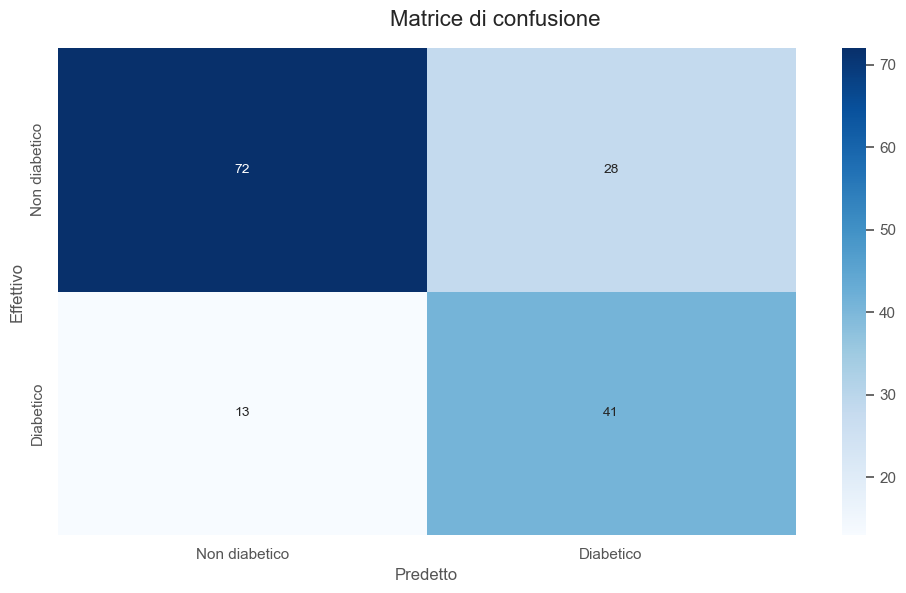

In [28]:
# Visualizzazione della matrice di confusione
fig = create_figure(6, "Matrice di confusione")
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non diabetico', 'Diabetico'],
            yticklabels=['Non diabetico', 'Diabetico'])
plt.xlabel('Predetto')
plt.ylabel('Effettivo')
plt.tight_layout()
plt.savefig('confusion_matrix.png')


Calcolo dell'importanza delle feature con analisi delle permutazioni...

Top 10 feature secondo l'analisi delle permutazioni:
                         Feature    Importance       Std
7                            Age  2.987013e-02  0.015692
1                        Glucose  1.558442e-02  0.024504
8         BMI_Category_Obesity 1  1.298701e-02  0.007683
17  Glucose_Category_Prediabetes  9.090909e-03  0.007792
5                            BMI  7.792208e-03  0.020493
9         BMI_Category_Obesity 2  3.246753e-03  0.007819
11       BMI_Category_Overweight  6.493506e-04  0.007926
12      BMI_Category_Underweight  0.000000e+00  0.000000
14       Insulin_Category_Normal  0.000000e+00  0.000000
13         Insulin_Category_High -1.110223e-17  0.002904


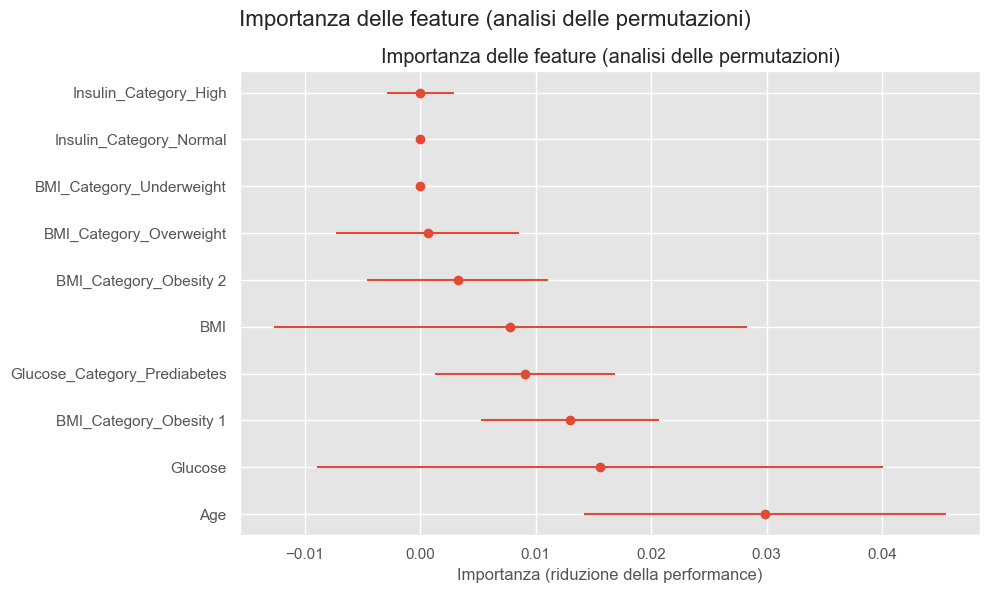

In [30]:
print("\nCalcolo dell'importanza delle feature con analisi delle permutazioni...")

from sklearn.inspection import permutation_importance

# Preprocessing manuale del test set
X_test_transformed = best_rf.named_steps['preprocessor'].transform(X_test)

# Calcola importanza permutazioni sul classificatore (senza preprocessore)
perm_importance = permutation_importance(best_rf.named_steps['classifier'],
                                        X_test_transformed,
                                        y_test,
                                        n_repeats=10,
                                        random_state=42)
preprocessor = best_rf.named_steps['preprocessor']
num_features = preprocessor.transformers_[0][2]
cat_features = preprocessor.transformers_[1][2]
ohe = preprocessor.transformers_[1][1].named_steps['onehot']
cat_feature_names = ohe.get_feature_names_out(cat_features)
all_features = list(num_features) + list(cat_feature_names)
# Controllo lunghezza feature
if len(all_features) != len(perm_importance.importances_mean):
    raise ValueError(f"Mismatch: {len(all_features)} features names vs {len(perm_importance.importances_mean)} permutation importances")

perm_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

print("\nTop 10 feature secondo l'analisi delle permutazioni:")
print(perm_importance_df.head(10))

fig = create_figure(9, "Importanza delle feature (analisi delle permutazioni)")
plt.errorbar(
    x=perm_importance_df['Importance'].head(10),
    y=range(10),
    xerr=perm_importance_df['Std'].head(10),
    fmt='o'
)
plt.yticks(range(10), perm_importance_df['Feature'].head(10))
plt.xlabel('Importanza (riduzione della performance)')
plt.title('Importanza delle feature (analisi delle permutazioni)')
plt.tight_layout()
plt.savefig('permutation_importance.png')



In [31]:
print("\nReport di classificazione:")
print(classification_report(y_test, y_pred))

# Curva ROC
fig = create_figure(7, "Curva ROC")
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)



Report di classificazione:
              precision    recall  f1-score   support

           0       0.85      0.72      0.78       100
           1       0.59      0.76      0.67        54

    accuracy                           0.73       154
   macro avg       0.72      0.74      0.72       154
weighted avg       0.76      0.73      0.74       154



NameError: name 'roc_auc' is not defined

<Figure size 1000x600 with 0 Axes>

In [63]:
# PDPs (Partial Dependence Plots) per le feature più importanti
try:
    print("\nCreazione dei Partial Dependence Plots (PDP) per le feature più importanti...")
    from sklearn.inspection import PartialDependenceDisplay

    # Troviamo le feature numeriche più importanti
    top_numeric_features = [f for f in feature_importance_df['Feature']
                           if f in numeric_columns][:3]

    fig, ax = plt.subplots(figsize=(12, 6))
    PartialDependenceDisplay.from_estimator(
        best_rf,
        X_test,
        top_numeric_features,
        kind="average",
        ax=ax
    )
    plt.tight_layout()
    plt.savefig('pdp_plots.png')
except Exception as e:
    print(f"Impossibile creare i PDP plots: {e}")



Creazione dei Partial Dependence Plots (PDP) per le feature più importanti...
Impossibile creare i PDP plots: name 'feature_importance_df' is not defined


In [64]:
print("\n9. SALVATAGGIO DEL MODELLO")
joblib.dump(best_rf, 'diabetes_rf_model.pkl')
print("Modello salvato come 'diabetes_rf_model.pkl'")


9. SALVATAGGIO DEL MODELLO
Modello salvato come 'diabetes_rf_model.pkl'


                                                        CREAZIONE DI UNA FUNZIONE DI PREVISIONE

In [65]:
print("\n10. FUNZIONE DI PREVISIONE PER NUOVI DATI")

def predict_diabetes(model, new_data):
    """
    Effettua previsioni su nuovi dati.

    Args:
        model: Modello addestrato
        new_data: DataFrame con i dati del paziente

    Returns:
        Probabilità di diabete e predizione
    """
    # Assicurarsi che tutte le colonne necessarie siano presenti
    required_cols = numeric_columns + categorical_columns
    for col in required_cols:
        if col not in new_data.columns:
            raise ValueError(f"Colonna mancante: {col}")

    # Effettuare la previsione
    prob = model.predict_proba(new_data[required_cols])[0, 1]
    pred = 1 if prob >= 0.5 else 0

    # Calcolo del rischio
    if prob < 0.2:
        risk_level = "Basso"
    elif prob < 0.5:
        risk_level = "Moderato"
    elif prob < 0.7:
        risk_level = "Alto"
    else:
        risk_level = "Molto alto"

    return {
        "probability": prob,
        "prediction": pred,
        "risk_level": risk_level
    }


10. FUNZIONE DI PREVISIONE PER NUOVI DATI


In [66]:
# Esempio di utilizzo della funzione di previsione in Jupyter Notebook

print("\nEsempio di utilizzo della funzione di previsione:")

sample_patient = X_test.iloc[0:1].copy()  # Primo paziente del test set come esempio

result = predict_diabetes(best_rf, sample_patient)

print("Dati del paziente:")
display(sample_patient[numeric_columns].T)  # Trasposto per visualizzazione verticale pulita

print(f"Probabilità di diabete: {result['probability']:.4f}")
print(f"Predizione: {'Diabetico' if result['prediction'] == 1 else 'Non diabetico'}")
print(f"Livello di rischio: {result['risk_level']}")
print(f"Valore reale: {'Diabetico' if y_test.iloc[0] == 1 else 'Non diabetico'}")



Esempio di utilizzo della funzione di previsione:
Dati del paziente:


,44
Pregnancies,7.000
Glucose,159.000
BloodPressure,64.000
SkinThickness,23.700
Insulin,249.150
BMI,27.400
DiabetesPedigreeFunction,0.294
Age,40.000


Probabilità di diabete: 0.6183
Predizione: Diabetico
Livello di rischio: Alto
Valore reale: Non diabetico
